In [1]:
from tensorflow.python.eager import backprop
from tensorflow.python.keras.engine import data_adapter
from tensorflow.python.keras.mixed_precision.experimental import loss_scale_optimizer as lso
from tensorflow.python.distribute import parameter_server_strategy
import tensorflow as tf
import pandas as pd
import numpy as np

import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors
plt.style.use('seaborn-whitegrid')

###Import self-written library
import featexlib.debug as dbug
import featexlib.datagen as dgen

Data is ok
Out shape X,Y is: (100000, 32, 84) (100000,)
Number of classes: 10000
Max class label (should starts from 0): 9999
Show first 10 images:


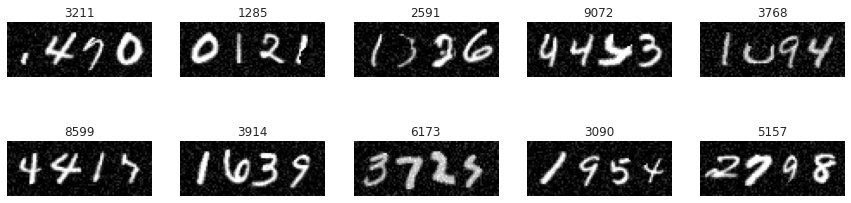

In [2]:
###Load data
###This cell should be used in another cell Can be used in another file

x_load, y_load = dgen.Image_generator.load_data()

###Get information about dataset
y_uniq = len(np.unique(y_load))
y_max = y_load.max()

###Check if data is consistent
print("Data is ok" if (y_max+1)==y_uniq else "Data is NOT consistent! Y values should be from 0 to MAX, without gaps!!!")

###Show some report. Label is uniq for each class but it doesnt related to "real" image values
print("===================================")
print("Out shape X,Y is:",x_load.shape, y_load.shape)
print("Number of classes:",y_uniq)
print("Max class label (should starts from 0):", y_max)
print("Show first 10 images:")
dbug.Debug.show_images_list(x_load[:10], y_load[:10], col_number = 5)

In [3]:
###Split data to test and train
n_train = 70000
n_test = 7000

def relabel_y(inp_y):
    inp_y_uniq = len(np.unique(inp_y))
    inp_y_max = inp_y.max()

    print("Number of classes:",inp_y_uniq)
    print("Max class label:", inp_y_max)
    print("Relabeling is not required" if (inp_y_max+1)==inp_y_uniq else "Y should be relabeled to 0-n")

    if not (inp_y_max+1)==inp_y_uniq:
        lookup_table = dict(zip(np.unique(inp_y), np.arange(len(np.unique(inp_y)))) )
        vect_lookup = np.vectorize(lookup_table.get)
        out_y = np.copy(inp_y)
        out_y = vect_lookup(out_y)
        print("Y was relabeled")
        print("New number of classes:", len(np.unique(out_y)))
        print("New max class label:", out_y.max())
        return out_y
    else:
        return inp_y

###Get X train and test
x_train, x_test = x_load[:n_train], x_load[n_train:n_train+n_test]

###Relabel Y array to make it from 0 to n. Relabel test and train together!!!
y_train_test = relabel_y(y_load[:n_train+n_test])
y_train, y_test = y_train_test[:n_train], y_train_test[n_train:n_train+n_test]
num_classes = len(np.unique(y_train_test))

print("===============Data is ready====================")
print("Shape X,Y for train:",x_train.shape,y_train.shape)
print("Shape X,Y for test: ",x_test.shape,y_test.shape)
print("Number of classes is:",num_classes)

###Clean memory
del x_load, y_load

Number of classes: 10000
Max class label: 9999
Relabeling is not required
===============Data is ready====================
Shape X,Y for train: (70000, 32, 84) (70000,)
Shape X,Y for test:  (7000, 32, 84) (7000,)
Number of classes is: 10000


In [4]:
###Reshape and then rescale dataset
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train.reshape(x_train.shape[0],-1))
x_test  = scaler.transform(x_test.reshape(x_test.shape[0],-1))

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(70000, 2688) (70000,) (7000, 2688) (7000,)


In [5]:
###Prepare for training: check labels dimension (-1), change X to float32 instead of float64
ys = y_train.astype(int).reshape(-1)
xs = x_train.astype('float32')
#ys_one_hot = tf.one_hot(ys, num_classes) ###not used

ys_test = y_test.astype(int).reshape(-1)
xs_test = x_test.astype('float32')

###Clear memory
del x_train, y_train, y_test, x_test

In [18]:
###Model parameters
pic_h = 32
pic_w = 84
num_feat = 128
#'num_classes' is defined before

###Minimizer taken from tf library. Actually, this code is redundant and can be simplified
def _minimize(strategy, tape, optimizer, loss, trainable_variables):
    """Minimizes loss for one step by updating `trainable_variables`.
    This is roughly equivalent to
    ```python
    gradients = tape.gradient(loss, trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, trainable_variables))
    ```
    However, this function also applies gradient clipping and loss scaling if the
    optimizer is a LossScaleOptimizer.
    Args:
    strategy: `tf.distribute.Strategy`.
    tape: A gradient tape. The loss must have been computed under this tape.
    optimizer: The optimizer used to minimize the loss.
    loss: The loss tensor.
    trainable_variables: The variables that will be updated in order to minimize
    the loss.
    """

    with tape:
        if isinstance(optimizer, lso.LossScaleOptimizer):
            loss = optimizer.get_scaled_loss(loss)

    gradients = tape.gradient(loss, trainable_variables)

    # Whether to aggregate gradients outside of optimizer. This requires support
    # of the optimizer and doesn't work with ParameterServerStrategy and
    # CentralStroageStrategy.
    aggregate_grads_outside_optimizer = (
        optimizer._HAS_AGGREGATE_GRAD and  # pylint: disable=protected-access
        not isinstance(strategy.extended,
                       parameter_server_strategy.ParameterServerStrategyExtended))

    if aggregate_grads_outside_optimizer:
        # We aggregate gradients before unscaling them, in case a subclass of
        # LossScaleOptimizer all-reduces in fp16. All-reducing in fp16 can only be
        # done on scaled gradients, not unscaled gradients, for numeric stability.
        gradients = optimizer._aggregate_gradients(zip(gradients,  # pylint: disable=protected-access
                                                       trainable_variables))
    if isinstance(optimizer, lso.LossScaleOptimizer):
        gradients = optimizer.get_unscaled_gradients(gradients)
    gradients = optimizer._clip_gradients(gradients)  # pylint: disable=protected-access
    if trainable_variables:
        if aggregate_grads_outside_optimizer:
            optimizer.apply_gradients(
                zip(gradients, trainable_variables),
                experimental_aggregate_gradients=False)
        else:
            optimizer.apply_gradients(zip(gradients, trainable_variables))

###Model build in low level way
class Model(tf.keras.Model):
    def __init__(self, cl_coeff, dropout_rate = 0.1, variance_epsilon=1e-3, stddev = 0.1, bias = 0.1):
        super(Model, self).__init__()
        
        ###Model is Lenet++ taken from 'A Discriminative Feature Learning Approachfor Deep Face Recognition'
        ###Num features is 'num_feat'
        ###Num classes is 'num_classes'
        
        #Input pixel numbers is pic_h*pic_w*1
        input_shape = (-1,pic_h,pic_w,1)
        
        ###Weights initialisation for convolution layers should be sqrt(2/k*k*c) as in Kaiming He's, 'Delving Deep into Rectifiers...')
        ###because using PReLU as activation function for Conv layers
        conv_init = tf.keras.initializers.he_normal()
        #conv_init = tf.random_normal_initializer(mean=0.0, stddev=stddev, seed=None)
        
        ###Biases initialisation for convolution layers. Should be zeroes.
        conv_bias_init = 'zeros'
        #conv_bias_init = tf.constant_initializer(bias)

        ###Model layers
        #1,2: (5/32)/1,2 x 2 PReLU
        #3: MaxPool 2/2,0
        #4,5: (5/64)/1,2 x 2 PReLU
        #6: MaxPool 2/2,0
        #7,8: (5/128)/1,2 x 2 PReLU
        #9: MaxPool 2/2,0 + Dropout
        #10: FC*num_feat - feature vector
        #11: FC*num_classes - output
        
        self.conv1_1 = tf.keras.layers.Conv2D(32, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init, input_shape=input_shape[1:])
        self.conv1_1_pr = self.get_conv_act(alpha=0.5)
        self.conv1_2 = tf.keras.layers.Conv2D(32, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init)
        self.conv1_2_pr = self.get_conv_act(alpha=0.5)
        self.pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='same')
        self.conv2_1 = tf.keras.layers.Conv2D(64, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init)
        self.conv2_1_pr = self.get_conv_act(alpha=0.3)
        self.conv2_2 = tf.keras.layers.Conv2D(64, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init)
        self.conv2_2_pr = self.get_conv_act(alpha=0.3)
        self.pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='same')
        
        ###For last two convolution layers added L1L2 regularizer
        self.conv3_1 = tf.keras.layers.Conv2D(128, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init, kernel_regularizer = self.get_regularizer(l1=0.01, l2=0.01))
        self.conv3_1_pr = self.get_conv_act(alpha=0.2)
        self.conv3_2 = tf.keras.layers.Conv2D(128, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init, kernel_regularizer = self.get_regularizer(l1=0.01, l2=0.01))
        self.conv3_2_pr = self.get_conv_act(alpha=0.2)
        self.pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='same')
        
        self.pool3_drop = tf.keras.layers.Dropout(dropout_rate)
        
        self.feat = tf.keras.layers.Dense(num_feat, kernel_regularizer = self.get_regularizer(l1=0.01, l2=0.01))
        self.out = tf.keras.layers.Dense(num_classes)
        
        ###Batch normalisation is not used
        #self.bn_conv1_2 = tf.keras.layers.BatchNormalization()
        #self.bn_conv2_2 = tf.keras.layers.BatchNormalization()
        #self.bn_conv3_2 = tf.keras.layers.BatchNormalization()
        #self.bn_feat = tf.keras.layers.BatchNormalization()
        #self.bn_out = tf.keras.layers.BatchNormalization()
        
        #Make centers tf.constants - because we update them manually
        self.centers = tf.constant(tf.zeros([num_classes,num_feat], dtype=tf.float32), name="centers")
        self.cl_coeff = cl_coeff
        self.dropout_rate = dropout_rate
        self.variance_epsilon = variance_epsilon
    
    def get_conv_act(self, alpha = 0.2):
        #return tf.keras.layers.LeakyReLU(alpha=alpha)
        return tf.keras.layers.PReLU(alpha_initializer = tf.constant_initializer(alpha))
    
    def get_regularizer(self,l1=0.01,l2=0.01):
        return tf.keras.regularizers.L1L2(l1=l1, l2=l2)
    
    def __call__(self, x, training=False):
        x_reshaped = tf.reshape(x, [-1,pic_h,pic_w,1])
        h_conv1_1 = self.conv1_1(x_reshaped)
        h_conv1_1_pr = self.conv1_1_pr(h_conv1_1)
        h_conv1_2 = self.conv1_2(h_conv1_1_pr)
        h_conv1_2_pr = self.conv1_2_pr(h_conv1_2)
        h_pool1 = self.pool1(h_conv1_2_pr)
        #h_pool1_bn = self.bn_conv1_2(h_pool1, training = training)
        
        tf.print("W Conv1 var:",tf.nn.moments(h_conv1_2,axes=[0,1,2,3])[1])
        
        h_conv2_1 = self.conv2_1(h_pool1)
        h_conv2_1_pr = self.conv2_1_pr(h_conv2_1)
        h_conv2_2 = self.conv2_2(h_conv2_1_pr)
        h_conv2_2_pr = self.conv2_2_pr(h_conv2_2)
        h_pool2 = self.pool2(h_conv2_2_pr)
        #h_pool2_bn = self.bn_conv2_2(h_pool2, training = training)
        
        tf.print("W Conv2 var:",tf.nn.moments(h_conv2_2,axes=[0,1,2,3])[1])
        
        h_conv3_1 = self.conv3_1(h_pool2)
        h_conv3_1_pr = self.conv3_1_pr(h_conv3_1)
        h_conv3_2 = self.conv3_2(h_conv3_1_pr)
        h_conv3_2_pr = self.conv3_2_pr(h_conv3_2)
        h_pool3 = self.pool3(h_conv3_2_pr)

        tf.print("W Conv3 var:",tf.nn.moments(h_conv3_2,axes=[0,1,2,3])[1])
        
        h_pool3_flt = tf.reshape(h_pool3, [-1,h_pool3.shape[1]*h_pool3.shape[2]*h_pool3.shape[3]])  #tf.reshape(h_pool3, self.get_flat_shape(h_pool3))
        #h_pool3_bn = self.bn_conv3_2(h_pool3_flt, training = training)
        
        h_pool3_flt_drop = self.pool3_drop(h_pool3_flt,training = training)

        h_feat = self.feat(h_pool3_flt_drop)
        
        tf.print("W Fc1   var:",tf.nn.moments(h_feat,axes=[0,1])[1])
        
        #features = self.bn_out(features, training = training)
        y_out = self.out(h_feat)
        
        #In case of library losses use softmax output
        return y_out, h_feat   #tf.nn.softmax(y_out)
    
    def set_center_loss_coeff(self, cl_coeff):
        self.cl_coeff = cl_coeff
    
    def get_center_loss(self, features, labels):
        labels = tf.reshape(labels, [-1])
        centers_batch = tf.gather(tf.stop_gradient(self.centers), labels)
        center_loss = tf.reduce_sum(input_tensor=(features - centers_batch) ** 2, axis=[1])
        return center_loss

    def centers_update(self, features, labels, alpha):
        labels = tf.reshape(labels, [-1])
        centers_batch = tf.gather(self.centers, labels)
        diff = centers_batch - features

        unique_label, unique_idx, unique_count = tf.unique_with_counts(labels)
        appear_times = tf.gather(unique_count, unique_idx)
        appear_times = tf.reshape(appear_times, [-1, 1])

        diff = diff / tf.cast((1 + appear_times), tf.float32)
        diff = alpha * diff
        
        label_reshaped = tf.reshape(labels,[-1,1])
        
        self.centers = tf.tensor_scatter_nd_sub(self.centers, label_reshaped, diff)
        
    def get_losses(self, x, y, training=False):
        y_pred, h_features = self(x, training=training)
        return self._get_losses(y, y_pred, h_features)

    def _get_losses(self, y, y_pred, h_features):
        y_one_hot = tf.one_hot(y, num_classes)
        center_loss = self.get_center_loss(h_features, y)
        softmax_loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf.stop_gradient(y_one_hot), logits=y_pred)
        tf.print("Using loss with center loss coeff:", self.cl_coeff)
        loss = tf.reduce_mean(input_tensor=(softmax_loss + self.cl_coeff * center_loss)) #    
        return loss, softmax_loss, center_loss
    
    def get_accuracy(self, x, y):
        y_pred, _ = self(x, training=False)
        result = tf.argmax(input=y_pred,axis=1)
        ground_truth = tf.reshape(y, [-1])
        correct_prediction = tf.equal(result, ground_truth)
        accuracy = tf.reduce_mean(input_tensor=tf.cast(correct_prediction, tf.float32))
        return accuracy
    
    def get_centers(self):
        return self.centers
    
    def train_step(self, data):
        data = data_adapter.expand_1d(data)
        x, y, sample_weight = data_adapter.unpack_x_y_sample_weight(data)

        with backprop.GradientTape() as tape:
            y_pred, h_features = self(x, training=True)
            ###Calculate centerloss but don't include it in loss function
            loss, softmax_loss, center_loss = self._get_losses(y, y_pred, h_features) 
            #Default loss cant be used...
            #loss = self.compiled_loss(y, y_pred, sample_weight, regularization_losses=self.losses)
        
        ###Simple optimiser, not used.
        #trainable_variables = self.trainable_variables
        #gradients = tape.gradient(loss, trainable_variables)
        #self.optimizer.apply_gradients(zip(gradients, trainable_variables))
        _minimize(self.distribute_strategy, tape, self.optimizer, loss,
                  self.trainable_variables)
        
        ###Update center loss    
        self.centers_update(h_features, y, 0.5) 
        
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
        
        #trace output
        tf.print({m.name: m.result() for m in self.metrics})
        
        return {m.name: m.result() for m in self.metrics}
    
    def save_model(self, name, save_dir = "models"):
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        self.save_weights(os.path.join(save_dir, name))

    def load_model(self, name, load_dir = "models"):
        self.load_weights(os.path.join(load_dir, name))
        
#Not used here, because can't implement center loss
class Softmax_and_center_loss(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        softmax_loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf.stop_gradient(y_true), logits=y_pred)
        loss = tf.reduce_mean(input_tensor=softmax_loss ) 
        return loss

#Helpful function to control center loss during training    
def center_loss_progress(n_prog,n_iter, koeff):
    return koeff*(n_prog+1)/(n_iter) if n_prog<n_iter else koeff    


In [7]:
###Train model with centerloss 0.1 dropout 0.15, batch size 256, 20 epochs (center loss needs more). Train/test accuracy = ...
model = Model(0.1, dropout_rate = 0.15, variance_epsilon=1e-3, stddev = 0.01, bias = 0.1)
model_loss = Softmax_and_center_loss()
opt = tf.keras.optimizers.Adam()#learning_rate=1e-4
bunch_len = 256
model.compile(opt, loss=model_loss, metrics=["accuracy"])

dataset = tf.data.Dataset.from_tensor_slices((xs, ys))
dataset_batches = dataset.batch(bunch_len)

n_epochs = 5
n_center_loss_progress = 5

for i in range(n_epochs):
    tf.print("Step #"+str(i))
    #loss, softmax_loss, center_loss = model.get_losses(xs, ys)
    #tf.print('Accuracy: ', model.get_accuracy(xs, ys))
    #tf.print('=== Full loss   :', loss)
    #tf.print('=== Softmax loss: ', softmax_loss)
    #tf.print('=== Center loss : ', tf.reduce_mean(center_loss))
    #tf.print('Centers: ', model.get_centers())
    for batch in dataset_batches:    
        model.set_center_loss_coeff(center_loss_progress(i,n_center_loss_progress,0.1))
        model.train_step(batch)
        
print("====================================================")
#print("Final accuracy should be discovered manually")
#print("Final train Accuracy:", model.get_accuracy(xs, ys))        
print("Final test Accuracy:", model.get_accuracy(xs_test, ys_test))     

Step #0
W Conv1 var: 2.33378386
W Conv2 var: 4.26066446
W Conv3 var: 4.86044836
W Fc1   var: 11.5447731
Using loss with center loss coeff: 0.02
{'accuracy': 0}
W Conv1 var: 2.00127339
W Conv2 var: 2.91532516
W Conv3 var: 1.64301193
W Fc1   var: 3.65594029
Using loss with center loss coeff: 0.02
{'accuracy': 0}
W Conv1 var: 1.76785147
W Conv2 var: 2.75325155
W Conv3 var: 1.08267832
W Fc1   var: 1.5619638
Using loss with center loss coeff: 0.02
{'accuracy': 0}
W Conv1 var: 1.64092326
W Conv2 var: 2.80030346
W Conv3 var: 0.725107431
W Fc1   var: 8.94340229
Using loss with center loss coeff: 0.02
{'accuracy': 0}
W Conv1 var: 1.55758142
W Conv2 var: 2.12424207
W Conv3 var: 1.23315215
W Fc1   var: 3.17681432
Using loss with center loss coeff: 0.02
{'accuracy': 0}
W Conv1 var: 1.48037124
W Conv2 var: 1.77056217
W Conv3 var: 1.57021439
W Fc1   var: 2.44348884
Using loss with center loss coeff: 0.02
{'accuracy': 0}
W Conv1 var: 1.47668433
W Conv2 var: 1.62933707
W Conv3 var: 1.72281241
W Fc1   

Using loss with center loss coeff: 0.02
{'accuracy': 7.51201951e-05}
W Conv1 var: 1.06535923
W Conv2 var: 0.658125281
W Conv3 var: 0.212163314
W Fc1   var: 0.0155974515
Using loss with center loss coeff: 0.02
{'accuracy': 7.37028313e-05}
W Conv1 var: 1.05688477
W Conv2 var: 0.646548
W Conv3 var: 0.217198238
W Fc1   var: 0.015610503
Using loss with center loss coeff: 0.02
{'accuracy': 7.23379635e-05}
W Conv1 var: 1.06377137
W Conv2 var: 0.648467302
W Conv3 var: 0.213186041
W Fc1   var: 0.0151974419
Using loss with center loss coeff: 0.02
{'accuracy': 7.1022725e-05}
W Conv1 var: 1.06360495
W Conv2 var: 0.645440638
W Conv3 var: 0.213919893
W Fc1   var: 0.0149377063
Using loss with center loss coeff: 0.02
{'accuracy': 6.97544674e-05}
W Conv1 var: 1.04483545
W Conv2 var: 0.638904452
W Conv3 var: 0.204871729
W Fc1   var: 0.0145410821
Using loss with center loss coeff: 0.02
{'accuracy': 6.85307e-05}
W Conv1 var: 1.05707991
W Conv2 var: 0.644873738
W Conv3 var: 0.206959084
W Fc1   var: 0.01458

W Conv3 var: 0.130745903
W Fc1   var: 0.00843318
Using loss with center loss coeff: 0.02
{'accuracy': 0.00011602723}
W Conv1 var: 1.01099837
W Conv2 var: 0.590872586
W Conv3 var: 0.126997754
W Fc1   var: 0.00829244591
Using loss with center loss coeff: 0.02
{'accuracy': 0.000114889706}
W Conv1 var: 1.01853311
W Conv2 var: 0.592726469
W Conv3 var: 0.12849319
W Fc1   var: 0.00826259516
Using loss with center loss coeff: 0.02
{'accuracy': 0.000113774273}
W Conv1 var: 1.03141785
W Conv2 var: 0.600204051
W Conv3 var: 0.128989011
W Fc1   var: 0.00816680305
Using loss with center loss coeff: 0.02
{'accuracy': 0.000112680289}
W Conv1 var: 1.0281657
W Conv2 var: 0.594405472
W Conv3 var: 0.12902087
W Fc1   var: 0.00803641696
Using loss with center loss coeff: 0.02
{'accuracy': 0.000111607143}
W Conv1 var: 1.02383626
W Conv2 var: 0.594306946
W Conv3 var: 0.126747653
W Fc1   var: 0.00793466
Using loss with center loss coeff: 0.02
{'accuracy': 0.000110554247}
W Conv1 var: 1.03012061
W Conv2 var: 0.

{'accuracy': 0.000157298651}
W Conv1 var: 1.00836742
W Conv2 var: 0.573742926
W Conv3 var: 0.102081493
W Fc1   var: 0.00675257761
Using loss with center loss coeff: 0.02
{'accuracy': 0.00015625}
W Conv1 var: 1.00407493
W Conv2 var: 0.570244789
W Conv3 var: 0.10085658
W Fc1   var: 0.00651635043
Using loss with center loss coeff: 0.02
{'accuracy': 0.000155215239}
W Conv1 var: 1.01507807
W Conv2 var: 0.577222
W Conv3 var: 0.103152774
W Fc1   var: 0.00651838
Using loss with center loss coeff: 0.02
{'accuracy': 0.000154194073}
W Conv1 var: 1.01517451
W Conv2 var: 0.579098
W Conv3 var: 0.102150574
W Fc1   var: 0.00657157786
Using loss with center loss coeff: 0.02
{'accuracy': 0.00015318628}
W Conv1 var: 1.00847423
W Conv2 var: 0.574432671
W Conv3 var: 0.099943243
W Fc1   var: 0.00659959391
Using loss with center loss coeff: 0.02
{'accuracy': 0.000152191555}
W Conv1 var: 1.02045274
W Conv2 var: 0.57744
W Conv3 var: 0.101862393
W Fc1   var: 0.00657477695
Using loss with center loss coeff: 0.02

W Fc1   var: 0.00614017714
Using loss with center loss coeff: 0.02
{'accuracy': 0.000157828283}
W Conv1 var: 0.994212389
W Conv2 var: 0.561230183
W Conv3 var: 0.0859804228
W Fc1   var: 0.00586805958
Using loss with center loss coeff: 0.02
{'accuracy': 0.000157035174}
W Conv1 var: 1.0080018
W Conv2 var: 0.567181528
W Conv3 var: 0.0880200043
W Fc1   var: 0.00605268311
Using loss with center loss coeff: 0.02
{'accuracy': 0.00015625}
W Conv1 var: 0.987511575
W Conv2 var: 0.557809711
W Conv3 var: 0.0863984
W Fc1   var: 0.00589248
Using loss with center loss coeff: 0.02
{'accuracy': 0.000155472633}
W Conv1 var: 0.999896705
W Conv2 var: 0.560598254
W Conv3 var: 0.0858950838
W Fc1   var: 0.00601018127
Using loss with center loss coeff: 0.02
{'accuracy': 0.000154702968}
W Conv1 var: 0.989527583
W Conv2 var: 0.559124887
W Conv3 var: 0.0864054114
W Fc1   var: 0.00617341325
Using loss with center loss coeff: 0.02
{'accuracy': 0.000153940884}
W Conv1 var: 1.01132143
W Conv2 var: 0.569229662
W Conv3

{'accuracy': 0.00028582316}
W Conv1 var: 0.998347878
W Conv2 var: 0.560334384
W Conv3 var: 0.0818415284
W Fc1   var: 0.00653358921
Using loss with center loss coeff: 0.02
{'accuracy': 0.000284666}
W Conv1 var: 1.00537086
W Conv2 var: 0.563202858
W Conv3 var: 0.0823321193
W Fc1   var: 0.00666520465
Using loss with center loss coeff: 0.02
{'accuracy': 0.000299269159}
W Conv1 var: 0.998762131
W Conv2 var: 0.56144923
W Conv3 var: 0.081506148
W Fc1   var: 0.00671199616
Using loss with center loss coeff: 0.02
{'accuracy': 0.000298067258}
W Conv1 var: 0.995410919
W Conv2 var: 0.559002817
W Conv3 var: 0.082524538
W Fc1   var: 0.00699070888
Using loss with center loss coeff: 0.02
{'accuracy': 0.000296875}
W Conv1 var: 0.996237457
W Conv2 var: 0.560311
W Conv3 var: 0.0797672123
W Fc1   var: 0.00689167483
Using loss with center loss coeff: 0.02
{'accuracy': 0.00029569224}
W Conv1 var: 0.99095583
W Conv2 var: 0.557192385
W Conv3 var: 0.0792118087
W Fc1   var: 0.00696674362
Using loss with center l

W Conv3 var: 0.0744460672
W Fc1   var: 0.0111908056
Using loss with center loss coeff: 0.04
{'accuracy': 0.000358204212}
W Conv1 var: 0.954995275
W Conv2 var: 0.479494095
W Conv3 var: 0.0690425485
W Fc1   var: 0.00937762111
Using loss with center loss coeff: 0.04
{'accuracy': 0.000356991746}
W Conv1 var: 0.955938458
W Conv2 var: 0.475714177
W Conv3 var: 0.0753154
W Fc1   var: 0.00967503712
Using loss with center loss coeff: 0.04
{'accuracy': 0.0003689648}
W Conv1 var: 0.958025694
W Conv2 var: 0.472184688
W Conv3 var: 0.0853811353
W Fc1   var: 0.00958168227
Using loss with center loss coeff: 0.04
{'accuracy': 0.000367724308}
W Conv1 var: 0.957940578
W Conv2 var: 0.4673886
W Conv3 var: 0.0964353308
W Fc1   var: 0.00983617827
Using loss with center loss coeff: 0.04
{'accuracy': 0.00037958115}
W Conv1 var: 0.95408392
W Conv2 var: 0.461250931
W Conv3 var: 0.105386369
W Fc1   var: 0.0119915903
Using loss with center loss coeff: 0.04
{'accuracy': 0.000378313503}
W Conv1 var: 0.935075462
W Con

W Fc1   var: 0.00614493154
Using loss with center loss coeff: 0.04
{'accuracy': 0.000832724967}
W Conv1 var: 0.917275727
W Conv2 var: 0.441584051
W Conv3 var: 0.058226835
W Fc1   var: 0.00636312552
Using loss with center loss coeff: 0.04
{'accuracy': 0.000864422182}
W Conv1 var: 0.916583717
W Conv2 var: 0.439904451
W Conv3 var: 0.0571715944
W Fc1   var: 0.00584439561
Using loss with center loss coeff: 0.04
{'accuracy': 0.000884594454}
W Conv1 var: 0.932036102
W Conv2 var: 0.44805181
W Conv3 var: 0.062782608
W Fc1   var: 0.00637684762
Using loss with center loss coeff: 0.04
{'accuracy': 0.000882033666}
W Conv1 var: 0.924903154
W Conv2 var: 0.444771707
W Conv3 var: 0.0622172579
W Fc1   var: 0.00612017047
Using loss with center loss coeff: 0.04
{'accuracy': 0.000902038591}
W Conv1 var: 0.92137748
W Conv2 var: 0.445086241
W Conv3 var: 0.0633685738
W Fc1   var: 0.00627046
Using loss with center loss coeff: 0.04
{'accuracy': 0.000910685398}
W Conv1 var: 0.922862291
W Conv2 var: 0.444021225
W

{'accuracy': 0.00144069153}
W Conv1 var: 0.942323148
W Conv2 var: 0.463358551
W Conv3 var: 0.0673992783
W Fc1   var: 0.0094726542
Using loss with center loss coeff: 0.04
{'accuracy': 0.00143701106}
W Conv1 var: 0.937445521
W Conv2 var: 0.462733775
W Conv3 var: 0.0667693391
W Fc1   var: 0.0108183837
Using loss with center loss coeff: 0.04
{'accuracy': 0.00145325693}
W Conv1 var: 0.952069342
W Conv2 var: 0.469463259
W Conv3 var: 0.071020782
W Fc1   var: 0.0108989226
Using loss with center loss coeff: 0.04
{'accuracy': 0.00146942015}
W Conv1 var: 0.936160862
W Conv2 var: 0.460611969
W Conv3 var: 0.0647072494
W Fc1   var: 0.00975895673
Using loss with center loss coeff: 0.04
{'accuracy': 0.00148550153}
W Conv1 var: 0.959302425
W Conv2 var: 0.47500211
W Conv3 var: 0.0747977
W Fc1   var: 0.0120182009
Using loss with center loss coeff: 0.04
{'accuracy': 0.00149162323}
W Conv1 var: 0.94449389
W Conv2 var: 0.466889232
W Conv3 var: 0.0708492696
W Fc1   var: 0.0117305974
Using loss with center lo

W Conv3 var: 0.0848854184
W Fc1   var: 0.02301066
Using loss with center loss coeff: 0.04
{'accuracy': 0.00189340068}
W Conv1 var: 0.952759147
W Conv2 var: 0.491180956
W Conv3 var: 0.0831399187
W Fc1   var: 0.0213043261
Using loss with center loss coeff: 0.04
{'accuracy': 0.0018979708}
W Conv1 var: 0.945975602
W Conv2 var: 0.484219402
W Conv3 var: 0.0796499476
W Fc1   var: 0.0199038014
Using loss with center loss coeff: 0.04
{'accuracy': 0.00189367123}
W Conv1 var: 0.951989651
W Conv2 var: 0.488778561
W Conv3 var: 0.0791015476
W Fc1   var: 0.020981282
Using loss with center loss coeff: 0.04
{'accuracy': 0.00189822}
W Conv1 var: 0.960496068
W Conv2 var: 0.49255085
W Conv3 var: 0.0827907324
W Fc1   var: 0.0230585
Using loss with center loss coeff: 0.04
{'accuracy': 0.00189393945}
W Conv1 var: 0.970125377
W Conv2 var: 0.498382568
W Conv3 var: 0.0860971361
W Fc1   var: 0.0223395973
Using loss with center loss coeff: 0.04
{'accuracy': 0.00190725632}
W Conv1 var: 0.958266914
W Conv2 var: 0.4

W Conv1 var: 0.987770617
W Conv2 var: 0.530462086
W Conv3 var: 0.10503877
W Fc1   var: 0.034481898
Using loss with center loss coeff: 0.04
{'accuracy': 0.00215930911}
W Conv1 var: 0.973311365
W Conv2 var: 0.521132231
W Conv3 var: 0.105828807
W Fc1   var: 0.0475530028
Using loss with center loss coeff: 0.04
{'accuracy': 0.0021548972}
W Conv1 var: 0.967890441
W Conv2 var: 0.519399285
W Conv3 var: 0.0994672552
W Fc1   var: 0.035191454
Using loss with center loss coeff: 0.04
{'accuracy': 0.00215846812}
W Conv1 var: 0.990664184
W Conv2 var: 0.535397708
W Conv3 var: 0.114516303
W Fc1   var: 0.0394489691
Using loss with center loss coeff: 0.04
{'accuracy': 0.00216997322}
W Conv1 var: 0.982825339
W Conv2 var: 0.531341732
W Conv3 var: 0.113017172
W Fc1   var: 0.0407642275
Using loss with center loss coeff: 0.04
{'accuracy': 0.0021734992}
W Conv1 var: 0.997029066
W Conv2 var: 0.536444366
W Conv3 var: 0.10988465
W Fc1   var: 0.0448370352
Using loss with center loss coeff: 0.04
{'accuracy': 0.0021

{'accuracy': 0.00248310622}
W Conv1 var: 1.00246716
W Conv2 var: 0.578833
W Conv3 var: 0.137068972
W Fc1   var: 0.0701330304
Using loss with center loss coeff: 0.04
{'accuracy': 0.00250755902}
W Conv1 var: 1.00488865
W Conv2 var: 0.577263534
W Conv3 var: 0.125573948
W Fc1   var: 0.0871992707
Using loss with center loss coeff: 0.04
{'accuracy': 0.00252466626}
W Conv1 var: 1.01213431
W Conv2 var: 0.58736521
W Conv3 var: 0.144726798
W Fc1   var: 0.0767324641
Using loss with center loss coeff: 0.04
{'accuracy': 0.00254171016}
W Conv1 var: 1.01456928
W Conv2 var: 0.582614183
W Conv3 var: 0.142596349
W Fc1   var: 0.0736402944
Using loss with center loss coeff: 0.04
{'accuracy': 0.00253700698}
W Conv1 var: 1.01434541
W Conv2 var: 0.584356666
W Conv3 var: 0.139776736
W Fc1   var: 0.0783501416
Using loss with center loss coeff: 0.04
{'accuracy': 0.00253953598}
W Conv1 var: 1.0146184
W Conv2 var: 0.591538
W Conv3 var: 0.150424048
W Fc1   var: 0.0660043508
Using loss with center loss coeff: 0.04


Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.00255102036}
W Conv1 var: 0.948765516
W Conv2 var: 0.470139
W Conv3 var: 0.117358483
W Fc1   var: 0.057849437
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.0025533454}
W Conv1 var: 0.945889235
W Conv2 var: 0.466808408
W Conv3 var: 0.120866105
W Fc1   var: 0.0602823086
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.00254897238}
W Conv1 var: 0.944189787
W Conv2 var: 0.461585104
W Conv3 var: 0.103817351
W Fc1   var: 0.0533134192
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.00254461425}
W Conv1 var: 0.945765376
W Conv2 var: 0.470727026
W Conv3 var: 0.115014896
W Fc1   var: 0.056460496
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.00254027103}
W Conv1 var: 0.931400657
W Conv2 var: 0.460897893
W Conv3 var: 0.0993893519
W Fc1   var: 0.0595894232
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.0025559105}
W C

W Fc1   var: 0.0751148909
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.00322781666}
W Conv1 var: 0.953364789
W Conv2 var: 0.505339503
W Conv3 var: 0.119705066
W Fc1   var: 0.0855291635
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.00326622534}
W Conv1 var: 0.948355436
W Conv2 var: 0.503552258
W Conv3 var: 0.120869741
W Fc1   var: 0.0769631118
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.0032920891}
W Conv1 var: 0.966745675
W Conv2 var: 0.523900628
W Conv3 var: 0.135887459
W Fc1   var: 0.0961037725
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.00331787067}
W Conv1 var: 0.954443276
W Conv2 var: 0.517670155
W Conv3 var: 0.129654795
W Fc1   var: 0.107842356
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.00333118695}
W Conv1 var: 0.970994413
W Conv2 var: 0.530422926
W Conv3 var: 0.14081566
W Fc1   var: 0.0973855
Using loss with center loss coeff: 0.06000000000000001
{'acc

W Fc1   var: 0.120390281
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.00514534861}
W Conv1 var: 0.97514832
W Conv2 var: 0.553135037
W Conv3 var: 0.136345655
W Fc1   var: 0.118023165
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.00525380811}
W Conv1 var: 0.970947564
W Conv2 var: 0.55690974
W Conv3 var: 0.143029064
W Fc1   var: 0.135775551
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.00532136904}
W Conv1 var: 0.979101837
W Conv2 var: 0.561507821
W Conv3 var: 0.14736101
W Fc1   var: 0.125379607
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.00535400072}
W Conv1 var: 0.964514792
W Conv2 var: 0.551266193
W Conv3 var: 0.134533376
W Fc1   var: 0.124972925
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.00539809512}
W Conv1 var: 0.972204685
W Conv2 var: 0.557092547
W Conv3 var: 0.140941978
W Fc1   var: 0.130103976
Using loss with center loss coeff: 0.06000000000000001
{'accura

Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.00866390578}
W Conv1 var: 0.985526383
W Conv2 var: 0.591554523
W Conv3 var: 0.155234367
W Fc1   var: 0.158717245
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.00875522383}
W Conv1 var: 0.974593222
W Conv2 var: 0.591685
W Conv3 var: 0.159965485
W Fc1   var: 0.162696213
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.00885715522}
W Conv1 var: 0.979524612
W Conv2 var: 0.58853066
W Conv3 var: 0.153635636
W Fc1   var: 0.166773066
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.00898593478}
W Conv1 var: 0.991489887
W Conv2 var: 0.5998106
W Conv3 var: 0.153474718
W Fc1   var: 0.184981808
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.00910352}
W Conv1 var: 0.971299767
W Conv2 var: 0.596536934
W Conv3 var: 0.157257915
W Fc1   var: 0.171524405
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.00920995697}
W Conv1 var

{'accuracy': 0.0145918783}
W Conv1 var: 0.996506453
W Conv2 var: 0.629223049
W Conv3 var: 0.169273064
W Fc1   var: 0.224758178
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.0147775682}
W Conv1 var: 0.987955928
W Conv2 var: 0.628098369
W Conv3 var: 0.166014805
W Fc1   var: 0.187011495
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.0149116348}
W Conv1 var: 1.01613986
W Conv2 var: 0.65764153
W Conv3 var: 0.182372481
W Fc1   var: 0.216890216
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.015065779}
W Conv1 var: 1.00815845
W Conv2 var: 0.655434906
W Conv3 var: 0.180966899
W Fc1   var: 0.220882684
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.0152246207}
W Conv1 var: 1.02748632
W Conv2 var: 0.671082199
W Conv3 var: 0.188163251
W Fc1   var: 0.228493556
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.0154339857}
W Conv1 var: 1.01421237
W Conv2 var: 0.652639687
W Conv3 var: 0.1794

W Fc1   var: 0.269550651
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.023784427}
W Conv1 var: 1.02265298
W Conv2 var: 0.679719508
W Conv3 var: 0.213759333
W Fc1   var: 0.282775819
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.0240351185}
W Conv1 var: 1.01997089
W Conv2 var: 0.679753065
W Conv3 var: 0.221395493
W Fc1   var: 0.268570721
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.0243141297}
W Conv1 var: 1.0110755
W Conv2 var: 0.676625669
W Conv3 var: 0.2092015
W Fc1   var: 0.286724985
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.0245587323}
W Conv1 var: 1.00794709
W Conv2 var: 0.666071713
W Conv3 var: 0.193844065
W Fc1   var: 0.291359574
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.0248316}
W Conv1 var: 1.01593375
W Conv2 var: 0.674217343
W Conv3 var: 0.198836967
W Fc1   var: 0.282586
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.0250701606

{'accuracy': 0.0299917795}
W Conv1 var: 0.957407713
W Conv2 var: 0.571483254
W Conv3 var: 0.181396499
W Fc1   var: 0.258166134
Using loss with center loss coeff: 0.08
{'accuracy': 0.0302578285}
W Conv1 var: 0.956837952
W Conv2 var: 0.575074
W Conv3 var: 0.189033821
W Fc1   var: 0.279126555
Using loss with center loss coeff: 0.08
{'accuracy': 0.0304731354}
W Conv1 var: 0.950198412
W Conv2 var: 0.55976
W Conv3 var: 0.174594447
W Fc1   var: 0.271224022
Using loss with center loss coeff: 0.08
{'accuracy': 0.0307289}
W Conv1 var: 0.956124067
W Conv2 var: 0.57915
W Conv3 var: 0.197998777
W Fc1   var: 0.26782769
Using loss with center loss coeff: 0.08
{'accuracy': 0.0309340674}
W Conv1 var: 0.936240256
W Conv2 var: 0.553576946
W Conv3 var: 0.173799247
W Fc1   var: 0.253061622
Using loss with center loss coeff: 0.08
{'accuracy': 0.0311705414}
W Conv1 var: 0.958504379
W Conv2 var: 0.561513066
W Conv3 var: 0.177303135
W Fc1   var: 0.266541928
Using loss with center loss coeff: 0.08
{'accuracy': 

W Fc1   var: 0.377682269
Using loss with center loss coeff: 0.08
{'accuracy': 0.046789784}
W Conv1 var: 0.94853735
W Conv2 var: 0.600907505
W Conv3 var: 0.190257207
W Fc1   var: 0.34264
Using loss with center loss coeff: 0.08
{'accuracy': 0.0471648499}
W Conv1 var: 0.939444304
W Conv2 var: 0.591582775
W Conv3 var: 0.184497938
W Fc1   var: 0.32037586
Using loss with center loss coeff: 0.08
{'accuracy': 0.0475950614}
W Conv1 var: 0.952352822
W Conv2 var: 0.593069255
W Conv3 var: 0.188986033
W Fc1   var: 0.32507661
Using loss with center loss coeff: 0.08
{'accuracy': 0.0480372272}
W Conv1 var: 0.944137752
W Conv2 var: 0.596333385
W Conv3 var: 0.189739987
W Fc1   var: 0.34541595
Using loss with center loss coeff: 0.08
{'accuracy': 0.0483538397}
W Conv1 var: 0.947704494
W Conv2 var: 0.604382217
W Conv3 var: 0.197850436
W Fc1   var: 0.348216414
Using loss with center loss coeff: 0.08
{'accuracy': 0.0487942}
W Conv1 var: 0.926123857
W Conv2 var: 0.577117562
W Conv3 var: 0.177413493
W Fc1   va

{'accuracy': 0.066323109}
W Conv1 var: 0.949571133
W Conv2 var: 0.629540861
W Conv3 var: 0.203741759
W Fc1   var: 0.35353893
Using loss with center loss coeff: 0.08
{'accuracy': 0.0666952878}
W Conv1 var: 0.958362579
W Conv2 var: 0.634994149
W Conv3 var: 0.192874074
W Fc1   var: 0.410849035
Using loss with center loss coeff: 0.08
{'accuracy': 0.0671443045}
W Conv1 var: 0.96573168
W Conv2 var: 0.638499498
W Conv3 var: 0.200062066
W Fc1   var: 0.462385416
Using loss with center loss coeff: 0.08
{'accuracy': 0.0675964579}
W Conv1 var: 0.977660239
W Conv2 var: 0.655032635
W Conv3 var: 0.219905302
W Fc1   var: 0.414156795
Using loss with center loss coeff: 0.08
{'accuracy': 0.0680028349}
W Conv1 var: 0.952006936
W Conv2 var: 0.621398747
W Conv3 var: 0.205329806
W Fc1   var: 0.36397928
Using loss with center loss coeff: 0.08
{'accuracy': 0.0684572309}
W Conv1 var: 0.972634435
W Conv2 var: 0.645834923
W Conv3 var: 0.223726362
W Fc1   var: 0.392291546
Using loss with center loss coeff: 0.08
{'

W Fc1   var: 0.441178292
Using loss with center loss coeff: 0.08
{'accuracy': 0.087894395}
W Conv1 var: 0.941307366
W Conv2 var: 0.646726906
W Conv3 var: 0.221008569
W Fc1   var: 0.392093807
Using loss with center loss coeff: 0.08
{'accuracy': 0.0883198604}
W Conv1 var: 0.962685168
W Conv2 var: 0.669166803
W Conv3 var: 0.229140729
W Fc1   var: 0.466756701
Using loss with center loss coeff: 0.08
{'accuracy': 0.0887755454}
W Conv1 var: 0.982456923
W Conv2 var: 0.68638283
W Conv3 var: 0.248374984
W Fc1   var: 0.550215065
Using loss with center loss coeff: 0.08
{'accuracy': 0.0892109275}
W Conv1 var: 0.972336531
W Conv2 var: 0.65314275
W Conv3 var: 0.228196502
W Fc1   var: 0.433654368
Using loss with center loss coeff: 0.08
{'accuracy': 0.0896609426}
W Conv1 var: 0.961776555
W Conv2 var: 0.646365702
W Conv3 var: 0.220929891
W Fc1   var: 0.4310112
Using loss with center loss coeff: 0.08
{'accuracy': 0.0901952162}
W Conv1 var: 0.977932692
W Conv2 var: 0.682410836
W Conv3 var: 0.227759048
W F

W Conv2 var: 0.687699914
W Conv3 var: 0.229431272
W Fc1   var: 0.576754093
Using loss with center loss coeff: 0.08
{'accuracy': 0.111858293}
W Conv1 var: 0.956873298
W Conv2 var: 0.675738037
W Conv3 var: 0.223958969
W Fc1   var: 0.58883214
Using loss with center loss coeff: 0.08
{'accuracy': 0.112344533}
W Conv1 var: 0.95426923
W Conv2 var: 0.667788386
W Conv3 var: 0.223510012
W Fc1   var: 0.497825563
Using loss with center loss coeff: 0.08
{'accuracy': 0.112840958}
W Conv1 var: 0.989093065
W Conv2 var: 0.712749362
W Conv3 var: 0.24318786
W Fc1   var: 0.524364829
Using loss with center loss coeff: 0.08
{'accuracy': 0.113369688}
W Conv1 var: 0.966952264
W Conv2 var: 0.691129923
W Conv3 var: 0.219684646
W Fc1   var: 0.55607295
Using loss with center loss coeff: 0.08
{'accuracy': 0.11380145}
W Conv1 var: 0.996222198
W Conv2 var: 0.723417819
W Conv3 var: 0.246064454
W Fc1   var: 0.530660033
Using loss with center loss coeff: 0.08
{'accuracy': 0.114295088}
W Conv1 var: 0.962049961
W Conv2 v

{'accuracy': 0.132297099}
W Conv1 var: 0.933681488
W Conv2 var: 0.597368956
W Conv3 var: 0.210803121
W Fc1   var: 0.484583855
Using loss with center loss coeff: 0.1
{'accuracy': 0.132587776}
W Conv1 var: 0.937624097
W Conv2 var: 0.59785831
W Conv3 var: 0.208071545
W Fc1   var: 0.431971669
Using loss with center loss coeff: 0.1
{'accuracy': 0.13296631}
W Conv1 var: 0.925845265
W Conv2 var: 0.625664413
W Conv3 var: 0.215854943
W Fc1   var: 0.486886322
Using loss with center loss coeff: 0.1
{'accuracy': 0.133351237}
W Conv1 var: 0.923823595
W Conv2 var: 0.64828968
W Conv3 var: 0.213158101
W Fc1   var: 0.581004858
Using loss with center loss coeff: 0.1
{'accuracy': 0.133668393}
W Conv1 var: 0.916932344
W Conv2 var: 0.604980171
W Conv3 var: 0.183998212
W Fc1   var: 0.501660645
Using loss with center loss coeff: 0.1
{'accuracy': 0.133974418}
W Conv1 var: 0.944710791
W Conv2 var: 0.617714584
W Conv3 var: 0.215207443
W Fc1   var: 0.459551066
Using loss with center loss coeff: 0.1
{'accuracy': 

W Conv1 var: 0.908436894
W Conv2 var: 0.612360656
W Conv3 var: 0.216132551
W Fc1   var: 0.637294888
Using loss with center loss coeff: 0.1
{'accuracy': 0.15800041}
W Conv1 var: 0.901078105
W Conv2 var: 0.58858794
W Conv3 var: 0.21404916
W Fc1   var: 0.579891801
Using loss with center loss coeff: 0.1
{'accuracy': 0.158516452}
W Conv1 var: 0.907643437
W Conv2 var: 0.586754382
W Conv3 var: 0.214130044
W Fc1   var: 0.581025124
Using loss with center loss coeff: 0.1
{'accuracy': 0.159085691}
W Conv1 var: 0.896688342
W Conv2 var: 0.584964216
W Conv3 var: 0.207011625
W Fc1   var: 0.586218596
Using loss with center loss coeff: 0.1
{'accuracy': 0.159640431}
W Conv1 var: 0.907664537
W Conv2 var: 0.60147965
W Conv3 var: 0.209426373
W Fc1   var: 0.633553267
Using loss with center loss coeff: 0.1
{'accuracy': 0.160214454}
W Conv1 var: 0.916009247
W Conv2 var: 0.610883057
W Conv3 var: 0.220323294
W Fc1   var: 0.618057728
Using loss with center loss coeff: 0.1
{'accuracy': 0.160760522}
W Conv1 var: 0

W Conv2 var: 0.600834787
W Conv3 var: 0.220940977
W Fc1   var: 0.601429701
Using loss with center loss coeff: 0.1
{'accuracy': 0.185608119}
W Conv1 var: 0.911700308
W Conv2 var: 0.628726661
W Conv3 var: 0.23926346
W Fc1   var: 0.68221128
Using loss with center loss coeff: 0.1
{'accuracy': 0.18615441}
W Conv1 var: 0.906688333
W Conv2 var: 0.623391449
W Conv3 var: 0.235897571
W Fc1   var: 0.648656
Using loss with center loss coeff: 0.1
{'accuracy': 0.186677113}
W Conv1 var: 0.913357854
W Conv2 var: 0.617624581
W Conv3 var: 0.224718451
W Fc1   var: 0.611796379
Using loss with center loss coeff: 0.1
{'accuracy': 0.187228099}
W Conv1 var: 0.920513153
W Conv2 var: 0.628705502
W Conv3 var: 0.225999698
W Fc1   var: 0.697739482
Using loss with center loss coeff: 0.1
{'accuracy': 0.187781379}
W Conv1 var: 0.914378583
W Conv2 var: 0.62238723
W Conv3 var: 0.233794942
W Fc1   var: 0.669425488
Using loss with center loss coeff: 0.1
{'accuracy': 0.18832083}
W Conv1 var: 0.905623496
W Conv2 var: 0.619

W Conv3 var: 0.230579421
W Fc1   var: 0.703127146
Using loss with center loss coeff: 0.1
{'accuracy': 0.212705627}
W Conv1 var: 0.889346898
W Conv2 var: 0.597466767
W Conv3 var: 0.212998897
W Fc1   var: 0.676594377
Using loss with center loss coeff: 0.1
{'accuracy': 0.213245913}
W Conv1 var: 0.904663444
W Conv2 var: 0.617854357
W Conv3 var: 0.224035084
W Fc1   var: 0.7391482
Using loss with center loss coeff: 0.1
{'accuracy': 0.213791564}
W Conv1 var: 0.919153929
W Conv2 var: 0.630640388
W Conv3 var: 0.22718361
W Fc1   var: 0.697449625
Using loss with center loss coeff: 0.1
{'accuracy': 0.214320794}
W Conv1 var: 0.890116215
W Conv2 var: 0.603050351
W Conv3 var: 0.219058722
W Fc1   var: 0.652246416
Using loss with center loss coeff: 0.1
{'accuracy': 0.214864716}
W Conv1 var: 0.899165034
W Conv2 var: 0.612915576
W Conv3 var: 0.221875504
W Fc1   var: 0.73516351
Using loss with center loss coeff: 0.1
{'accuracy': 0.215392247}
W Conv1 var: 0.896244407
W Conv2 var: 0.60646373
W Conv3 var: 0.

Using loss with center loss coeff: 0.1
{'accuracy': 0.239084974}
W Conv1 var: 0.868733
W Conv2 var: 0.588325858
W Conv3 var: 0.215024516
W Fc1   var: 0.68437773
Using loss with center loss coeff: 0.1
{'accuracy': 0.239572361}
W Conv1 var: 0.888932109
W Conv2 var: 0.608102322
W Conv3 var: 0.220221475
W Fc1   var: 0.745315075
Using loss with center loss coeff: 0.1
{'accuracy': 0.240109846}
W Conv1 var: 0.878475487
W Conv2 var: 0.595356643
W Conv3 var: 0.213248521
W Fc1   var: 0.771054387
Using loss with center loss coeff: 0.1
{'accuracy': 0.240628585}
W Conv1 var: 0.901459455
W Conv2 var: 0.625066459
W Conv3 var: 0.224751607
W Fc1   var: 0.693380296
Using loss with center loss coeff: 0.1
{'accuracy': 0.24115549}
W Conv1 var: 0.892886758
W Conv2 var: 0.616198063
W Conv3 var: 0.211439222
W Fc1   var: 0.788835406
Using loss with center loss coeff: 0.1
{'accuracy': 0.241669655}
W Conv1 var: 0.875637233
W Conv2 var: 0.595863
W Conv3 var: 0.207388178
W Fc1   var: 0.669922113
Using loss with ce

Using loss with center loss coeff: 0.1
{'accuracy': 0.26448524}
W Conv1 var: 0.853727877
W Conv2 var: 0.572753429
W Conv3 var: 0.207895592
W Fc1   var: 0.740881801
Using loss with center loss coeff: 0.1
{'accuracy': 0.264982}
W Conv1 var: 0.874180377
W Conv2 var: 0.603570223
W Conv3 var: 0.218524337
W Fc1   var: 0.819310367
Using loss with center loss coeff: 0.1
{'accuracy': 0.265472293}
W Conv1 var: 0.868406177
W Conv2 var: 0.593454659
W Conv3 var: 0.219652906
W Fc1   var: 0.692064524
Using loss with center loss coeff: 0.1
{'accuracy': 0.265964746}
W Conv1 var: 0.857495427
W Conv2 var: 0.594797671
W Conv3 var: 0.21017395
W Fc1   var: 0.818323
Using loss with center loss coeff: 0.1
{'accuracy': 0.266456455}
W Conv1 var: 0.85843
W Conv2 var: 0.593712211
W Conv3 var: 0.211106703
W Fc1   var: 0.837121189
Using loss with center loss coeff: 0.1
{'accuracy': 0.266964704}
W Conv1 var: 0.859177351
W Conv2 var: 0.573967695
W Conv3 var: 0.211998031
W Fc1   var: 0.664004683
Using loss with center

In [12]:
###Save model after training
model.save_model("dig4_128f_e5_cl01_acc088")    

In [20]:
###Load model and retrain
model = Model(0.1, dropout_rate = 0.15, variance_epsilon=1e-3, stddev = 0.01, bias = 0.1)
model_loss = Softmax_and_center_loss()
opt = tf.keras.optimizers.Adam()#learning_rate=1e-4
bunch_len = 256
model.compile(opt, loss=model_loss, metrics=["accuracy"])
model.load_model("dig4_128f_e5_cl01_acc088") 
    
dataset = tf.data.Dataset.from_tensor_slices((xs, ys))
dataset_batches = dataset.batch(bunch_len)

n_epochs = 1
n_center_loss_progress = 5

for i in range(n_epochs):
    tf.print("Step #"+str(i))
    #loss, softmax_loss, center_loss = model.get_losses(xs, ys)
    #tf.print('Accuracy: ', model.get_accuracy(xs, ys))
    #tf.print('=== Full loss   :', loss)
    #tf.print('=== Softmax loss: ', softmax_loss)
    #tf.print('=== Center loss : ', tf.reduce_mean(center_loss))
    #tf.print('Centers: ', model.get_centers())
    for batch in dataset_batches:    
        model.set_center_loss_coeff(center_loss_progress(i,n_center_loss_progress,0.1))
        model.train_step(batch)
        
print("====================================================")

Step #0
W Conv1 var: 0.852401376
W Conv2 var: 0.579342365
W Conv3 var: 0.206285521
W Fc1   var: 0.726625919
Using loss with center loss coeff: 0.02
{'accuracy': 0.6953125}
W Conv1 var: 0.853065193
W Conv2 var: 0.576066434
W Conv3 var: 0.208188191
W Fc1   var: 0.686941803
Using loss with center loss coeff: 0.02
{'accuracy': 0.755859375}
W Conv1 var: 0.848153412
W Conv2 var: 0.561729312
W Conv3 var: 0.20927079
W Fc1   var: 0.618988335
Using loss with center loss coeff: 0.02
{'accuracy': 0.77734375}
W Conv1 var: 0.859656394
W Conv2 var: 0.571206093
W Conv3 var: 0.219936803
W Fc1   var: 0.632297039
Using loss with center loss coeff: 0.02
{'accuracy': 0.717773438}
W Conv1 var: 0.850153804
W Conv2 var: 0.57793355
W Conv3 var: 0.228428617
W Fc1   var: 0.686730802
Using loss with center loss coeff: 0.02
{'accuracy': 0.728125}
W Conv1 var: 0.838516414
W Conv2 var: 0.567587435
W Conv3 var: 0.225139543
W Fc1   var: 0.717642844
Using loss with center loss coeff: 0.02
{'accuracy': 0.751953125}
W Co

{'accuracy': 0.923958361}
W Conv1 var: 0.905166
W Conv2 var: 0.644985378
W Conv3 var: 0.24833934
W Fc1   var: 0.759014726
Using loss with center loss coeff: 0.02
{'accuracy': 0.925017}
W Conv1 var: 0.890243411
W Conv2 var: 0.629715323
W Conv3 var: 0.237477899
W Fc1   var: 0.783255577
Using loss with center loss coeff: 0.02
{'accuracy': 0.926113725}
W Conv1 var: 0.875335515
W Conv2 var: 0.61527431
W Conv3 var: 0.2300203
W Fc1   var: 0.82708168
Using loss with center loss coeff: 0.02
{'accuracy': 0.927246094}
W Conv1 var: 0.869425118
W Conv2 var: 0.609079242
W Conv3 var: 0.228119284
W Fc1   var: 0.817515373
Using loss with center loss coeff: 0.02
{'accuracy': 0.928172827}
W Conv1 var: 0.900200963
W Conv2 var: 0.641442657
W Conv3 var: 0.245862827
W Fc1   var: 0.78091532
Using loss with center loss coeff: 0.02
{'accuracy': 0.929218769}
W Conv1 var: 0.895946205
W Conv2 var: 0.637569785
W Conv3 var: 0.241053537
W Fc1   var: 0.797118902
Using loss with center loss coeff: 0.02
{'accuracy': 0.9

{'accuracy': 0.954276323}
W Conv1 var: 0.917399645
W Conv2 var: 0.663718343
W Conv3 var: 0.259335488
W Fc1   var: 0.803509355
Using loss with center loss coeff: 0.02
{'accuracy': 0.954671204}
W Conv1 var: 0.901729107
W Conv2 var: 0.654324174
W Conv3 var: 0.255832493
W Fc1   var: 0.895419598
Using loss with center loss coeff: 0.02
{'accuracy': 0.955017745}
W Conv1 var: 0.938969195
W Conv2 var: 0.702420533
W Conv3 var: 0.269274652
W Fc1   var: 0.943819523
Using loss with center loss coeff: 0.02
{'accuracy': 0.955317259}
W Conv1 var: 0.901846647
W Conv2 var: 0.664592743
W Conv3 var: 0.25924179
W Fc1   var: 0.86656177
Using loss with center loss coeff: 0.02
{'accuracy': 0.955610812}
W Conv1 var: 0.90139246
W Conv2 var: 0.668767154
W Conv3 var: 0.264075398
W Fc1   var: 0.770765126
Using loss with center loss coeff: 0.02
{'accuracy': 0.956015646}
W Conv1 var: 0.904561162
W Conv2 var: 0.675391316
W Conv3 var: 0.261133462
W Fc1   var: 0.861857831
Using loss with center loss coeff: 0.02
{'accur

Using loss with center loss coeff: 0.02
{'accuracy': 0.966460109}
W Conv1 var: 0.923498631
W Conv2 var: 0.700985134
W Conv3 var: 0.289446741
W Fc1   var: 0.897628307
Using loss with center loss coeff: 0.02
{'accuracy': 0.966689825}
W Conv1 var: 0.93293345
W Conv2 var: 0.711854398
W Conv3 var: 0.29492414
W Fc1   var: 0.897006869
Using loss with center loss coeff: 0.02
{'accuracy': 0.966810167}
W Conv1 var: 0.922038376
W Conv2 var: 0.703473151
W Conv3 var: 0.282475799
W Fc1   var: 0.928789496
Using loss with center loss coeff: 0.02
{'accuracy': 0.967008}
W Conv1 var: 0.943079829
W Conv2 var: 0.734572232
W Conv3 var: 0.292087823
W Fc1   var: 0.944028378
Using loss with center loss coeff: 0.02
{'accuracy': 0.967150807}
W Conv1 var: 0.923801422
W Conv2 var: 0.7046538
W Conv3 var: 0.27274394
W Fc1   var: 0.904693
Using loss with center loss coeff: 0.02
{'accuracy': 0.9673177}
W Conv1 var: 0.920359492
W Conv2 var: 0.696407616
W Conv3 var: 0.26951167
W Fc1   var: 0.908806443
Using loss with ce

W Fc1   var: 1.01037049
Using loss with center loss coeff: 0.02
{'accuracy': 0.973157048}
W Conv1 var: 0.928641617
W Conv2 var: 0.713717222
W Conv3 var: 0.287321121
W Fc1   var: 0.965318501
Using loss with center loss coeff: 0.02
{'accuracy': 0.973254144}
W Conv1 var: 0.946028948
W Conv2 var: 0.736651719
W Conv3 var: 0.296793222
W Fc1   var: 0.934028387
Using loss with center loss coeff: 0.02
{'accuracy': 0.973350227}
W Conv1 var: 0.954358935
W Conv2 var: 0.745022118
W Conv3 var: 0.297971249
W Fc1   var: 0.961747766
Using loss with center loss coeff: 0.02
{'accuracy': 0.973465145}
W Conv1 var: 0.934966147
W Conv2 var: 0.724211812
W Conv3 var: 0.296163738
W Fc1   var: 0.996114
Using loss with center loss coeff: 0.02
{'accuracy': 0.973578811}
W Conv1 var: 0.956356764
W Conv2 var: 0.747247696
W Conv3 var: 0.307000577
W Fc1   var: 1.02229941
Using loss with center loss coeff: 0.02
{'accuracy': 0.973691404}
W Conv1 var: 0.933061719
W Conv2 var: 0.728530586
W Conv3 var: 0.299337924
W Fc1   v

W Conv3 var: 0.311109036
W Fc1   var: 0.967947304
Using loss with center loss coeff: 0.02
{'accuracy': 0.9777264}
W Conv1 var: 0.937843
W Conv2 var: 0.739603281
W Conv3 var: 0.298752069
W Fc1   var: 1.01481414
Using loss with center loss coeff: 0.02
{'accuracy': 0.977801085}
W Conv1 var: 0.96328336
W Conv2 var: 0.767881215
W Conv3 var: 0.304011703
W Fc1   var: 1.0409615
Using loss with center loss coeff: 0.02
{'accuracy': 0.977875113}
W Conv1 var: 0.969295323
W Conv2 var: 0.771672845
W Conv3 var: 0.302175164
W Fc1   var: 1.03455913
Using loss with center loss coeff: 0.02
{'accuracy': 0.977948606}
W Conv1 var: 0.951997399
W Conv2 var: 0.75271976
W Conv3 var: 0.296966612
W Fc1   var: 1.01402354
Using loss with center loss coeff: 0.02
{'accuracy': 0.978021443}
W Conv1 var: 0.953477383
W Conv2 var: 0.768824458
W Conv3 var: 0.304139912
W Fc1   var: 1.01008081
Using loss with center loss coeff: 0.02
{'accuracy': 0.978093743}
W Conv1 var: 0.947236896
W Conv2 var: 0.744387
W Conv3 var: 0.29057

In [21]:
print("Final test Accuracy:", model.get_accuracy(xs_test, ys_test))  

W Conv1 var: 0.967493951
W Conv2 var: 0.770631254
W Conv3 var: 0.31330511
W Fc1   var: 1.03149676
Final test Accuracy: tf.Tensor(0.984, shape=(), dtype=float32)


In [22]:
###Save model after training
model.save_model("dig4_128f_e5_cl01_acc0984")    

In [8]:
#Get predictions and features for test dataframe
y_pred_logits, features_tf = model(xs_test)
features = np.array(features_tf)
y_pred_label = np.array(tf.argmax(y_pred_logits, axis=1))

W Conv1 var: 0.856205583
W Conv2 var: 0.581325293
W Conv3 var: 0.206250504
W Fc1   var: 0.72748965


In [27]:
###Show centers coords
np.array(model.centers)

array([[ -1.9242867 ,  -1.2769696 ],
       [  4.4159355 , -13.351339  ],
       [ -8.732005  ,   7.309432  ],
       [-15.808876  ,  -7.420747  ],
       [ -0.93458784,  12.040671  ],
       [-16.497854  ,   1.0617944 ],
       [  7.046907  ,  10.372195  ],
       [ -4.2405353 , -11.8541565 ],
       [  9.1233015 ,  -4.6500025 ],
       [  9.741671  ,   2.439099  ]], dtype=float32)

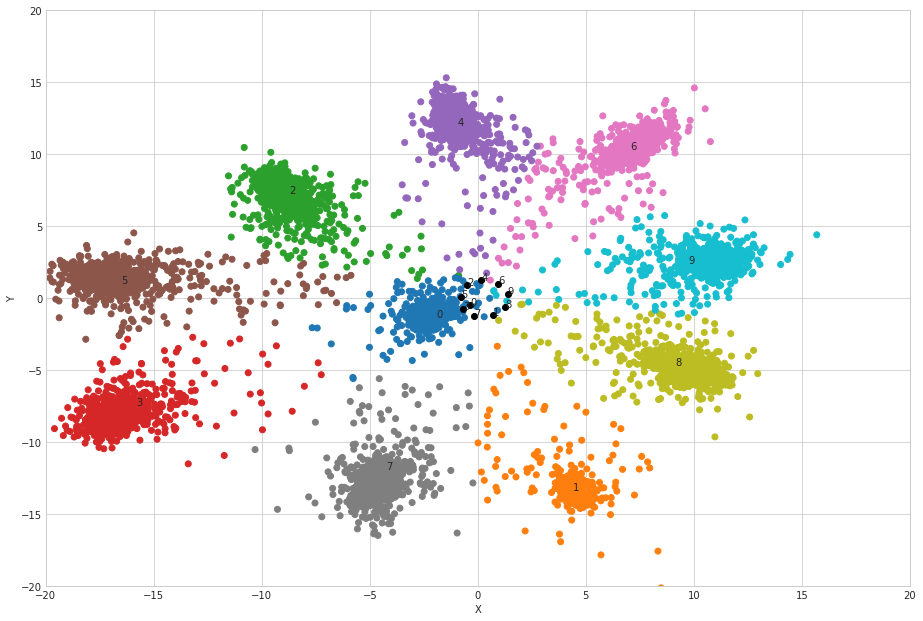

In [28]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)



class Plot_Report(object):
    def __init__(self, centers, class_vectors):
        self.fig = plt.figure()
        self.ax = self.fig.add_axes([-2,-2,2,2])
        self.centers = centers
        self.class_vectors = class_vectors
        self.center_names = ["0","1","2","3","4","5","6","7","8","9"]
        self.cmap = colors.ListedColormap(['#1f77b4', '#ff7f0e', 
                              '#2ca02c', '#d62728', 
                              '#9467bd', '#8c564b', 
                              '#e377c2', '#7f7f7f', 
                              '#bcbd22', '#17becf'])
        #self.cmap = discrete_cmap(10, 'cubehelix')
        
    def plot_data(self,x,y,c):
        self.ax.scatter(x,y, c=c , cmap=self.cmap, vmin=0, vmax=9) #, c=1 cmap=cmap
        
    def plot_centers(self):
        self.ax.scatter(self.centers[:,0],self.centers[:,1], c=[i for i in range(10)] , cmap=self.cmap, vmin=0, vmax=9) #, c=1 cmap=cmap
        for i, txt in enumerate(self.center_names):
            self.ax.annotate(txt, (self.centers[i,0], self.centers[i,1]))
        self.ax.set_xlabel('X')
        self.ax.set_ylabel('Y')
    def plot_class_vectors(self):
        self.ax.scatter(self.class_vectors[0],self.class_vectors[1], c="black")
        for i, txt in enumerate(self.center_names):
            self.ax.annotate(txt, (self.class_vectors[0,i], self.class_vectors[1,i]))
        self.ax.set_xlabel('X')
        self.ax.set_ylabel('Y')
        
    def show(self):
        plt.xlim(-20, 20)
        plt.ylim(-20, 20)
        plt.show()
        
myplot = Plot_Report(np.array(model.centers), model.out.weights[0].numpy())

myplot.plot_data(features[:,0],features[:,1],y_pred_label)
myplot.plot_centers()
myplot.plot_class_vectors()
myplot.show()

In [29]:
np.array(model.centers)

array([[ -1.9242867 ,  -1.2769696 ],
       [  4.4159355 , -13.351339  ],
       [ -8.732005  ,   7.309432  ],
       [-15.808876  ,  -7.420747  ],
       [ -0.93458784,  12.040671  ],
       [-16.497854  ,   1.0617944 ],
       [  7.046907  ,  10.372195  ],
       [ -4.2405353 , -11.8541565 ],
       [  9.1233015 ,  -4.6500025 ],
       [  9.741671  ,   2.439099  ]], dtype=float32)

In [53]:
#Classification vectors
cv_x = model.out.weights[0].numpy()[0]
cv_y = model.out.weights[0].numpy()[0]

In [58]:
model.out.weights[0]

<tf.Variable 'dense_3/kernel:0' shape=(2, 10) dtype=float32, numpy=
array([[ 0.88432413,  0.68028337, -0.6672186 ,  1.2843869 , -0.15179698,
         1.276881  ,  0.08845953, -1.0143772 ,  0.2778069 , -0.8433039 ],
       [-1.3016163 ,  1.279158  , -1.2335091 , -0.55072093,  1.2718129 ,
         0.6290787 , -1.4957021 , -0.35204726,  0.9666587 ,  0.6032002 ]],
      dtype=float32)>